# Refining fish mask

In [366]:
from builtins import map

import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from src.models import InputImage
from src.fish import sobel_edges, yen_thresholding, get_meniscus, convex_hull_for_fish, sobel
from src.well import find_well_props

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Getting bounding box of well
_____________________________________________________________
# Applying Yen-thresholding
_____________________________________________________________
# Stored binary image in object
_____________________________________________________________
# Getting convex hull for fish
_____________________________________________________________
# Getting bounding box of well
_____________________________________________________________
# Stored fish mask & bounding box
_____________________________________________________________


Text(0.5, 1.0, 'Fish mask')

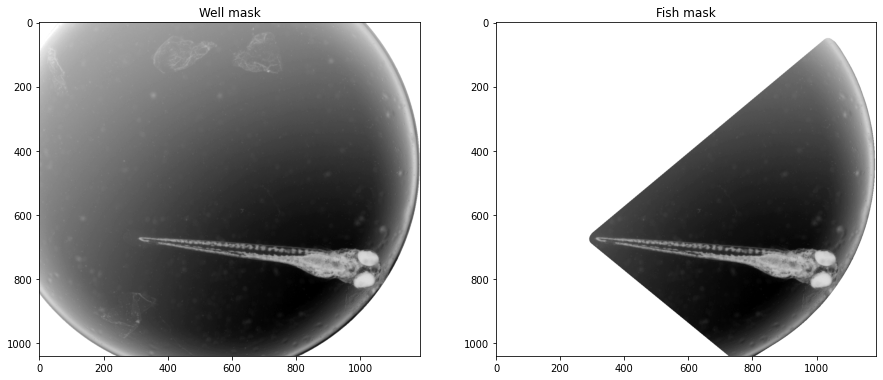

In [367]:
fishy = InputImage("zf2.jpg")
fishy = find_well_props(fishy)

fishy = sobel_edges(fishy)

fishy = yen_thresholding(fishy)

meniscus = get_meniscus(fishy)
without_meniscus = fishy.binary
without_meniscus[meniscus > 0] = 0  # Switching the pixels of the meniscus to 0
fishy.processed = without_meniscus

fishy = convex_hull_for_fish(fishy)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].imshow(fishy.well_props.mask.cropped_masked, "binary")
ax[0].set_title('Well mask')
ax[1].imshow(fishy.fish_props.mask.masked, "binary")
ax[1].set_title('Fish mask')

(array([9.03435e+05, 1.75200e+04, 1.78310e+04, 1.79550e+04, 1.75700e+04,
        1.73580e+04, 1.63680e+04, 1.61060e+04, 1.52500e+04, 1.45110e+04,
        1.36920e+04, 1.25410e+04, 1.16420e+04, 1.05250e+04, 9.98700e+03,
        9.04000e+03, 8.14200e+03, 7.34700e+03, 6.62200e+03, 6.19400e+03,
        5.53400e+03, 4.98600e+03, 4.37400e+03, 3.89300e+03, 3.47100e+03,
        3.11400e+03, 2.83700e+03, 2.61200e+03, 2.31100e+03, 2.06300e+03,
        1.91200e+03, 1.71500e+03, 1.61900e+03, 1.38600e+03, 1.32700e+03,
        1.14600e+03, 1.12300e+03, 1.01200e+03, 9.38000e+02, 9.42000e+02,
        8.20000e+02, 7.88000e+02, 7.64000e+02, 7.10000e+02, 6.98000e+02,
        6.63000e+02, 6.05000e+02, 5.66000e+02, 5.61000e+02, 5.25000e+02,
        4.80000e+02, 4.69000e+02, 4.20000e+02, 4.19000e+02, 4.30000e+02,
        3.86000e+02, 3.84000e+02, 3.70000e+02, 3.76000e+02, 3.45000e+02,
        3.42000e+02, 3.20000e+02, 2.99000e+02, 3.15000e+02, 3.07000e+02,
        2.89000e+02, 3.02000e+02, 2.75000e+02, 2.81

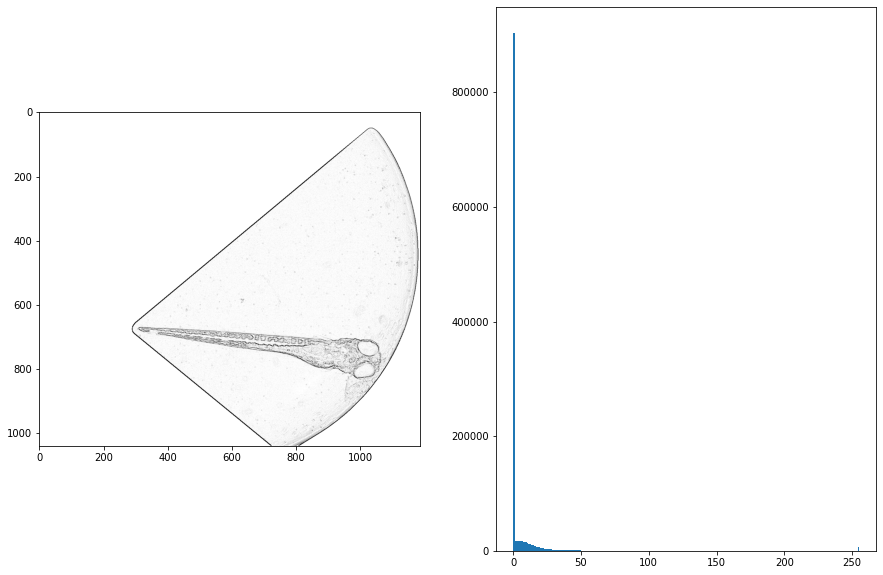

In [368]:
from skimage.exposure import equalize_hist
from src.filters.sharpen_img import sharpen_img

bbox = fishy.fish_props.bounding_box
img_ = fishy.processed
# img = img_#[bbox.x1:bbox.x2, bbox.y1:bbox.y2]

img = sobel(img_, equalized=False)
img = sharpen_img(img)
eq= equalize_hist()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].imshow(img, "binary")
ax[1].hist(img.ravel(), bins=255)

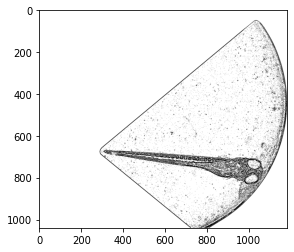

In [369]:
from src.fish import yen_th
from src.fish.sharpen_img import sharpen_img

from skimage.measure import label

f = fishy.binary  #[bbox.x1:bbox.x2, bbox.y1:bbox.y2]
masked_f = f * img
yen = yen_th(img)

plt.imshow(yen, "binary")



0
34206


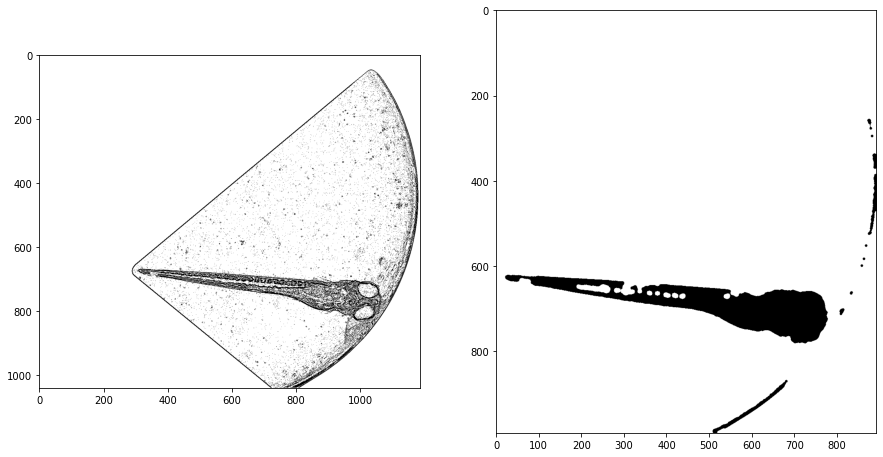

In [378]:
from skimage.morphology import binary_closing, disk, binary_erosion, closing, dilation, erosion, opening, white_tophat, \
    black_tophat
from skimage.measure import regionprops, regionprops_table
from src.fish import yen_th, keep_largest_object

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

ax[0].imshow(yen, "binary")

labeled = label(yen)
props = regionprops_table(labeled, properties=('area', 'label'))

max_area = props['area'].max()
max_index = np.where(props['area'] == max_area)[0][0]

region_props = regionprops(labeled)[max_index]

print(max_index)
print(props['area'][max_index])
print(region_props)

corrected = region_props.image_filled
corrected = closing(opening(corrected, disk(3)), disk(5))
new_bbox = region_props.bbox

ax[0].imshow(yen, "binary")
ax[1].imshow(corrected, "binary")

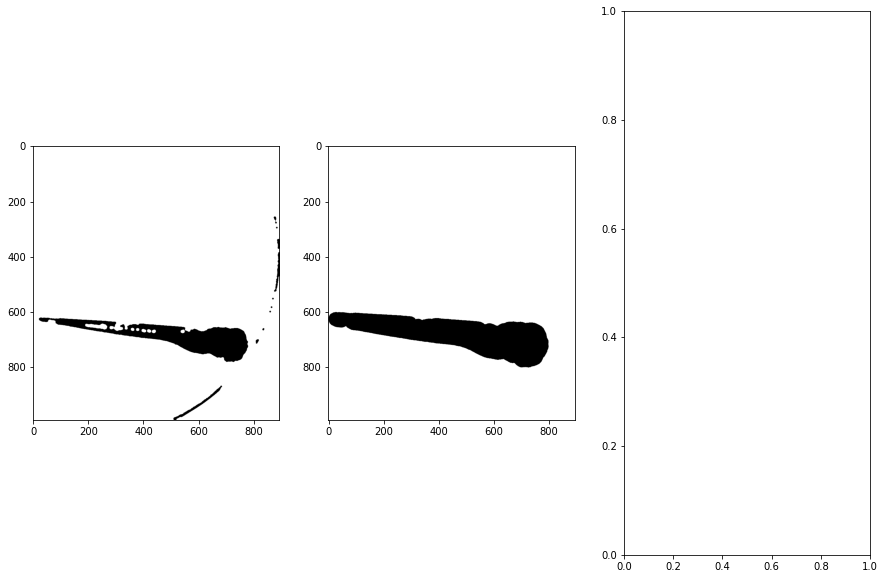

In [377]:
from src.fish import get_menisc

men = keep_largest_object(corrected)
men = dilation(men,disk(20))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
ax[0].imshow(corrected, "binary")
ax[1].imshow(men, "binary")
ax[1].imshow(men*, "binary")